/content/drive/MyDrive/creditcard_sample.csv/content/drive/MyDrive/creditcard_sample.csv
✓ Successfully loaded /content/drive/MyDrive/creditcard_sample.csv

--- Column Mapping ---
Your dataset's columns are: ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']
Please tell us which columns correspond to the required fields.
Enter the name of the TARGET column (e.g., 'Class', 'IsFraud'): fraud
Enter the name of the transaction AMOUNT column: ratio_to_median_purchase_price

Enter the names of any CATEGORICAL columns you want to use, separated by commas.
(e.g., 'Type', 'Location'). Press Enter to skip if there are none.
> 

--- Mapping Summary ---
Target column 'fraud' will be treated as 'IsFraud'.
Numerical features to be used: ['distance_from_home', 'distance_from_last_transaction', 'Amount', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']
Categorical featu

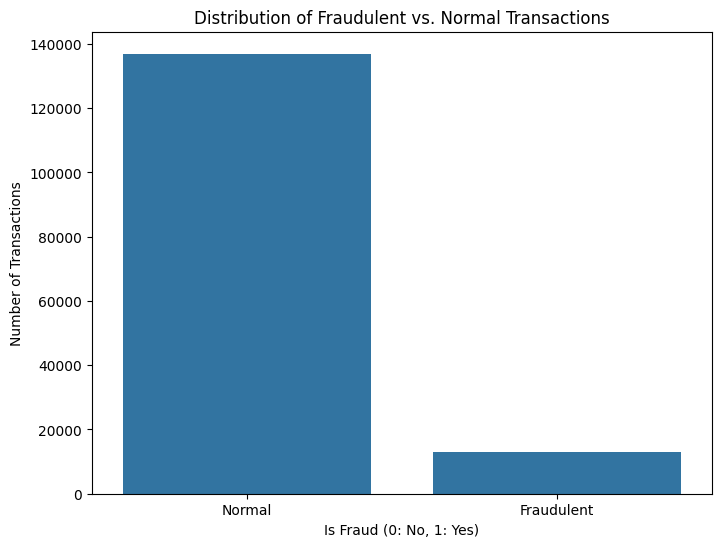


--- Value Counts ---
IsFraud
0.0    136947
1.0     13053
Name: count, dtype: int64

The dataset is imbalanced, which is a key challenge in fraud detection.

--- Comparing Purchase Price Ratio ---


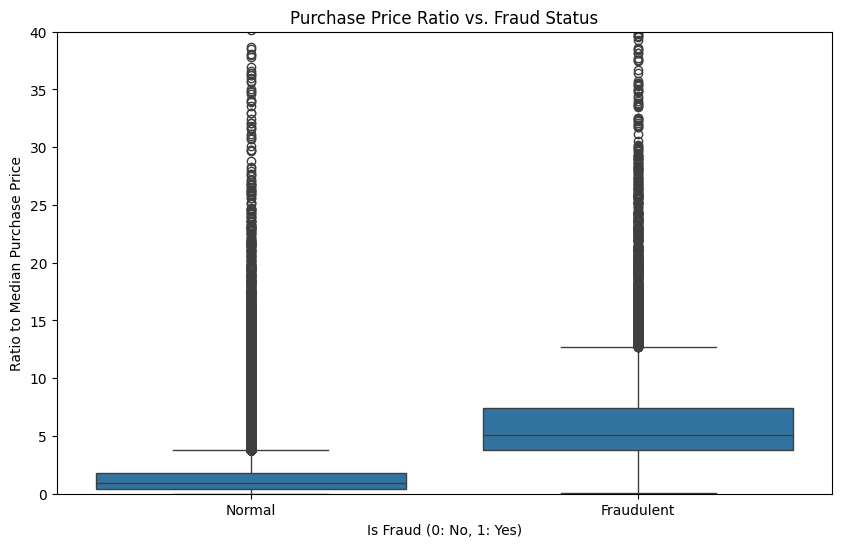

This plot helps us see if fraudulent transactions have a significantly different value.

--- Analyzing Fraud in Online Orders ---


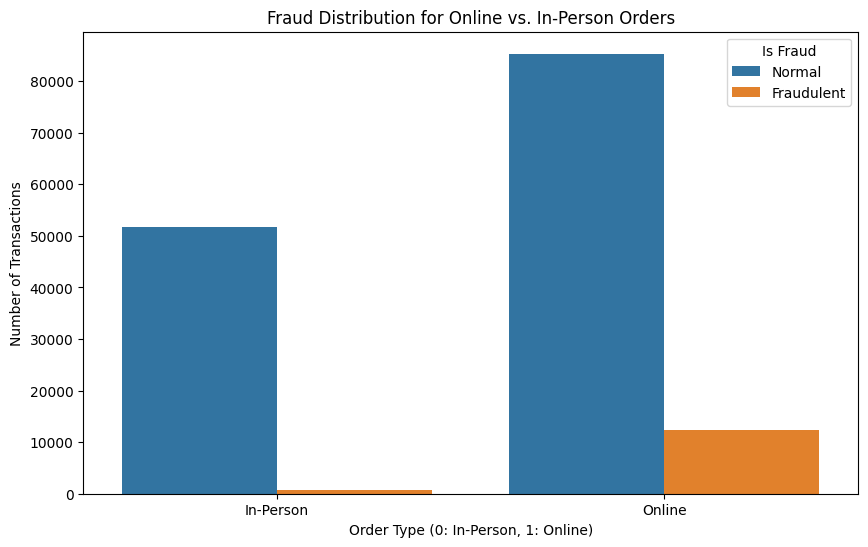

This plot shows if online orders are more susceptible to fraud.

--- Training the Model ---
✓ Model training complete.

Model Accuracy: 0.9352
Note: Accuracy can be misleading in imbalanced datasets. We need to look deeper.

--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.99      0.93      0.96     27389
  Fraudulent       0.58      0.95      0.72      2611

    accuracy                           0.94     30000
   macro avg       0.79      0.94      0.84     30000
weighted avg       0.96      0.94      0.94     30000

Key metrics to watch for fraud (class 1):
- Recall: How many of the actual fraudulent transactions did we catch?
- Precision: Of the transactions we flagged as fraud, how many were actually fraudulent?

--- Confusion Matrix ---


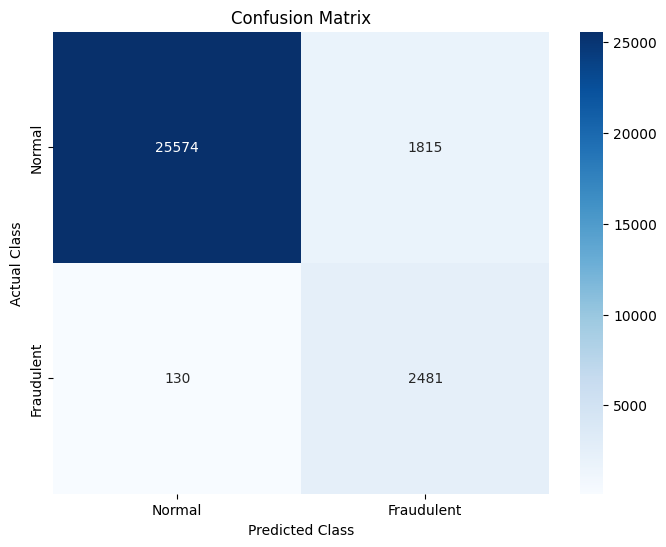


--- Business Insight ---
Based on our model, we are successfully identifying approximately 95.02% of all fraudulent transactions.
This model provides a strong foundation for an automated system to flag suspicious activity for review, saving the bank and its customers from potential losses.


In [7]:
# Bank Transaction Fraud Detector

# --- 1. Import Necessary Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import sys

# --- 2. Interactive Data Loading and Column Mapping ---
# This section allows the user to load their own data and map their columns
# to the names expected by the script.

def load_and_map_data():
    """
    Interactively prompts the user for a file path, loads the data,
    and asks the user to map their column names to the required names.
    """
    # --- Part A: Load the data ---
    while True:
        file_path = input("/content/drive/MyDrive/creditcard_sample.csv")
        try:
            df = pd.read_csv(file_path)
            print(f"✓ Successfully loaded {file_path}\n")
            break
        except FileNotFoundError:
            print(f"Error: The file was not found at '{file_path}'. Please check the path and try again.")
        except Exception as e:
            print(f"An error occurred: {e}")

        retry = input("Would you like to try again? (yes/no): ").lower()
        if retry != 'yes':
            return None, None, None # Return None if loading fails

    # --- Part B: Map the columns ---
    print("--- Column Mapping ---")
    print("Your dataset's columns are:", df.columns.tolist())
    print("Please tell us which columns correspond to the required fields.")

    def get_user_column(prompt, df_columns):
        while True:
            col_name = input(prompt)
            if col_name in df_columns:
                return col_name
            print(f"Error: Column '{col_name}' not found. Please choose from the list above.")

    # Get essential columns from user
    target_col = get_user_column("Enter the name of the TARGET column (e.g., 'Class', 'IsFraud'): ", df.columns)
    amount_col = get_user_column("Enter the name of the transaction AMOUNT column: ", df.columns)

    # Get optional categorical columns
    print("\nEnter the names of any CATEGORICAL columns you want to use, separated by commas.")
    print("(e.g., 'Type', 'Location'). Press Enter to skip if there are none.")
    cat_cols_input = input("> ")
    user_categorical_cols = [col.strip() for col in cat_cols_input.split(',') if col.strip() in df.columns]

    # Rename columns for consistency within the script
    rename_map = {
        target_col: 'IsFraud',
        amount_col: 'Amount'
    }
    df.rename(columns=rename_map, inplace=True)

    # Identify final feature lists
    all_feature_cols = [col for col in df.columns if col != 'IsFraud']
    final_categorical_features = [col for col in user_categorical_cols if col in all_feature_cols]
    final_numerical_features = [col for col in all_feature_cols if col not in final_categorical_features]

    print("\n--- Mapping Summary ---")
    print(f"Target column '{target_col}' will be treated as 'IsFraud'.")
    print(f"Numerical features to be used: {final_numerical_features}")
    print(f"Categorical features to be used: {final_categorical_features}\n")

    return df, final_numerical_features, final_categorical_features


# Load the data using the interactive function
df, numerical_features, categorical_features = load_and_map_data()

# If data loading was unsuccessful, exit the script.
if df is None:
    print("No data was loaded. Exiting the program.")
    sys.exit()

# --- 3. Exploratory Data Analysis (EDA) & Visualization ---
# This step helps us understand the data before modeling, tailored to card_transdata.csv.

# --- Plot 1: Visualize the class imbalance ---
print("\n--- Visualizing Class Imbalance ---")
plt.figure(figsize=(8, 6))
sns.countplot(x='IsFraud', data=df)
# This dataset is also imbalanced, but less extremely. A log scale may not be needed.
# If the 'Fraud' bar is too small, uncomment the next line:
# ax.set_yscale('log')
plt.title('Distribution of Fraudulent vs. Normal Transactions')
plt.xlabel('Is Fraud (0: No, 1: Yes)')
plt.ylabel('Number of Transactions')
plt.xticks([0, 1], ['Normal', 'Fraudulent'])
plt.show()

print("\n--- Value Counts ---")
print(df['IsFraud'].value_counts())
print("\nThe dataset is imbalanced, which is a key challenge in fraud detection.")

# --- Plot 2: Compare purchase price ratio for both classes ---
print("\n--- Comparing Purchase Price Ratio ---")
plt.figure(figsize=(10, 6))
sns.boxplot(x='IsFraud', y='Amount', data=df)
plt.title('Purchase Price Ratio vs. Fraud Status')
plt.xlabel('Is Fraud (0: No, 1: Yes)')
plt.ylabel('Ratio to Median Purchase Price')
plt.xticks([0, 1], ['Normal', 'Fraudulent'])
# Limiting the y-axis to see the box distributions more clearly, as there can be outliers
plt.ylim(0, 40) # This value can be adjusted
plt.show()
print("This plot helps us see if fraudulent transactions have a significantly different value.")

# --- Plot 3: Analyze fraud rate for online vs. in-person orders ---
print("\n--- Analyzing Fraud in Online Orders ---")
plt.figure(figsize=(10, 6))
sns.countplot(x='online_order', hue='IsFraud', data=df)
plt.title('Fraud Distribution for Online vs. In-Person Orders')
plt.xlabel('Order Type (0: In-Person, 1: Online)')
plt.ylabel('Number of Transactions')
plt.xticks([0, 1], ['In-Person', 'Online'])
plt.legend(title='Is Fraud', labels=['Normal', 'Fraudulent'])
plt.show()
print("This plot shows if online orders are more susceptible to fraud.")

# --- 4. Data Preprocessing (The Data Pipeline) ---
# We use the dynamically identified feature lists from step 2.

# Define features (X) and target (y)
X = df.drop('IsFraud', axis=1)
y = df['IsFraud']

# Create a preprocessing pipeline for numerical features (scaling)
numerical_transformer = StandardScaler()

# Create a preprocessing pipeline for categorical features (one-hot encoding)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# --- 5. Model Training ---
# We will now define our machine learning model and train it.

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the model. We use Logistic Regression.
# `class_weight='balanced'` is crucial for imbalanced datasets.
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Create the full pipeline by chaining the preprocessor and the model
full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])

# Train the model
print("\n--- Training the Model ---")
full_pipeline.fit(X_train, y_train)
print("✓ Model training complete.")


# --- 6. Model Evaluation ---
# This is where we check how well our model performs on unseen data.

# Make predictions on the test set
y_pred = full_pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")
print("Note: Accuracy can be misleading in imbalanced datasets. We need to look deeper.")

# Print the classification report (Precision, Recall, F1-Score)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraudulent']))
print("Key metrics to watch for fraud (class 1):")
print("- Recall: How many of the actual fraudulent transactions did we catch?")
print("- Precision: Of the transactions we flagged as fraud, how many were actually fraudulent?")

# Generate and visualize the confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraudulent'],
            yticklabels=['Normal', 'Fraudulent'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


# --- 7. Presenting Business Insight ---
# The results directly translate to business value.
# The recall for the 'Fraudulent' class tells us the percentage of actual fraud we successfully detected.
print("\n--- Business Insight ---")
recall_fraud = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
print(f"Based on our model, we are successfully identifying approximately {recall_fraud:.2%} of all fraudulent transactions.")
print("This model provides a strong foundation for an automated system to flag suspicious activity for review, saving the bank and its customers from potential losses.")